# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: user 511 ms, sys: 50 ms, total: 561 ms
Wall time: 574 ms


,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,...,address_count_30,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,fulladdress_count_7,address_count_7,address_count_0_by_30,record,fraud_label
0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,0.0
1,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,2.0,1.0
2,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,3.0,0.0
3,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,4.0,0.0
4,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'homephone_count_7',
 'zip5_count_1',
 'max_count_by_homephone_3',
 'fulladdress_count_30',
 'max_count_by_fulladdress_7',
 'max_count_by_homephone_30',
 'fulladdress_day_since',
 'ssn_count_30']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0
1,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0
2,3.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0
3,4.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0
4,5.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0


In [5]:
vars.shape

(1000000, 12)

In [6]:
vars['Fraud'].sum()

14393.0

In [7]:
vars.head(10)

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0
1,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0
2,3.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0
3,4.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0
4,5.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0
5,6.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,12.0,0.0,1.0
6,7.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,8.0,0.0,1.0
7,8.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,1.0
8,9.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0
9,10.0,0.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,12.0,0.0,1.0


In [8]:
vars.shape

(1000000, 12)

In [9]:
vars.describe()

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,1.199908,1.055732,1.935565,1.511174,3.315778,1.064739,1.084788,8.511320,39.952181,1.050924
std,288675.278932,0.119104,1.555354,0.772917,1.214552,0.960615,1.834058,0.633947,0.996835,4.039978,99.111297,0.513573
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,250000.750000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,7.000000,0.000000,1.000000
50%,500000.500000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,9.000000,0.000000,1.000000
75%,750000.250000,0.000000,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,11.000000,0.000000,1.000000
max,1000000.000000,1.000000,54.000000,34.000000,33.000000,33.000000,32.000000,30.000000,30.000000,50.000000,365.000000,34.000000


In [10]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.199908,1.055732,1.935565,1.511174,3.315778,1.064739,1.084788,8.511320,39.952181,1.050924
std,1.555354,0.772917,1.214552,0.960615,1.834058,0.633947,0.996835,4.039978,99.111297,0.513573
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,7.000000,0.000000,1.000000
50%,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,9.000000,0.000000,1.000000
75%,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,11.000000,0.000000,1.000000
max,54.000000,34.000000,33.000000,33.000000,32.000000,30.000000,30.000000,50.000000,365.000000,34.000000


In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# use this to cap variables. For some problems it helps
Clip = 10

In [14]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,1.402967e-17,-2.475176e-17,6.128431e-18,-2.647482e-17,-5.586998e-17,-9.031886e-17,-2.214051e-17,-1.076472e-17,-1.160743e-16,-4.512657e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.659633e-01,-9.468038e-02,-7.916143e-01,-5.723235e-01,-1.299119e+00,-1.328419e-01,-1.004119e-01,-1.861493e+00,-4.031042e-01,-1.385946e-01
25%,-1.659633e-01,-9.468038e-02,-7.916143e-01,-5.723235e-01,-1.748944e-01,-1.328419e-01,-1.004119e-01,-3.744425e-01,-4.031042e-01,-1.385946e-01
50%,-1.659633e-01,-9.468038e-02,5.704125e-02,-5.723235e-01,-1.748944e-01,-1.328419e-01,-1.004119e-01,1.212411e-01,-4.031042e-01,-1.385946e-01
75%,-1.659633e-01,-9.468038e-02,5.704125e-02,5.584938e-01,3.872181e-01,-1.328419e-01,-1.004119e-01,6.169247e-01,-4.031042e-01,-1.385946e-01
max,1.449903e+01,1.824326e+01,1.030972e+01,1.086853e+01,1.031208e+01,1.585223e+01,1.528096e+01,1.001288e+01,3.279624e+00,1.703702e+01


In [15]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [17]:
alphas = 10**np.linspace(2,9,30)*0.5

In [18]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [19]:
# %%time
# ridge = Ridge()
# coefs = []
# for a in alphas: 
#     ridge.set_params(alpha=a) 
#     ridge.fit(X_trn,Y_trn.values.ravel()) 
#     coefs.append(ridge.coef_) 
# print(np.shape(coefs))

# %matplotlib inline
# ax = plt.gca() # Get the current Axes instance
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# plt.xlabel('alpha') 
# plt.ylabel('standadized coef') 
# plt.title('Ridge')
# plt.savefig('ridge.png')

In [20]:
# %%time
# # sometimes this cell takes a long time. It's fine to comment out this cell since it's not really important
# alphas = 10**np.linspace(-5,0,30)*0.5
# lasso = Lasso(max_iter=10000) 
# coefs = [] 
# for a in alphas: 
#     lasso.set_params(alpha=a) 
#     lasso.fit(X_trn,Y_trn.values.ravel()) 
#     coefs.append(lasso.coef_) 
# # print('Shape:',np.shape(coefs)
# print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

# %matplotlib inline
# ax = plt.gca() # Get the current Axes instance 
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# plt.xlabel('alpha')
# plt.ylabel('standerdized coef') 
# plt.title('Lasso')
# plt.legend()
# plt.savefig('lasso.png')

## Look at PCA

In [21]:
len(X_trntst.columns)

10

In [22]:
X_trntst_save = X_trntst.copy()

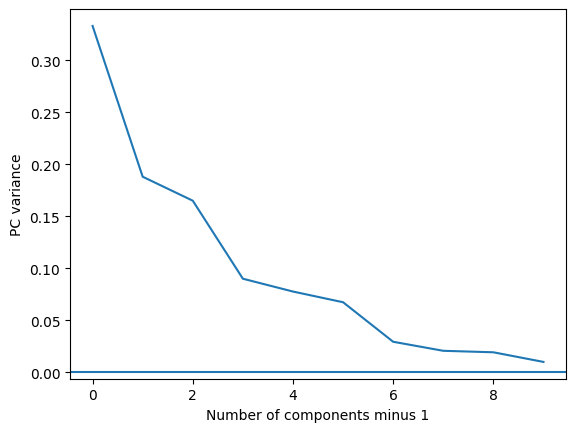

In [23]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [24]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-0.656019,0.074459,-0.097360,-0.281994
1,-0.387121,-0.479267,0.153415,-0.306019
2,-0.771736,0.344725,-0.229647,-0.266239
3,-0.502839,-0.209001,0.021128,-0.290264
4,-0.560697,-0.073869,-0.045015,-0.282387


In [25]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
833507,0.276820,-0.007242,0.361780,-1.569842
833508,-1.425248,1.722442,-0.863483,-0.202434
833509,2.900553,1.672622,1.952509,-2.343753
833510,-1.040633,0.898451,-0.480422,-0.242214
833511,-0.518356,0.383176,-0.434325,0.637870


In [26]:
X_trntst.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.001982,-0.001123,-0.001046,-0.000449,-0.000264,0.000321,0.001752,0.000159,-0.031511,-0.001817
std,1.006220,0.989478,1.000361,1.003332,0.998779,1.004381,1.012285,0.999543,0.981284,0.988286
min,-0.165963,-0.094680,-0.791614,-0.572324,-1.299119,-0.132842,-0.100412,-1.861493,-0.403104,-0.138595
25%,-0.165963,-0.094680,-0.791614,-0.572324,-0.174894,-0.132842,-0.100412,-0.374442,-0.403104,-0.138595
50%,-0.165963,-0.094680,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,0.121241,-0.403104,-0.138595
75%,-0.165963,-0.094680,0.057041,0.558494,0.387218,-0.132842,-0.100412,0.616925,-0.403104,-0.138595
max,14.499030,18.243255,10.309721,10.868526,10.312079,15.852230,15.280956,10.012880,3.279624,17.037019


In [27]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.040499,0.038348,0.032612,-0.094926
std,1.772191,1.387443,1.324092,0.976607
min,-1.425248,-13.212933,-11.223583,-4.715301
25%,-0.576214,-0.648659,-0.361934,-0.313897
50%,-0.191459,-0.081126,-0.031217,-0.259314
75%,0.246416,0.628185,0.264421,0.605015
max,31.842330,13.856326,24.419521,9.593413


In [28]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [29]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,-1.554912e-17,1.704947e-19,-7.672263e-18,-1.773145e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.819790e-01,-9.226548e+00,-9.227569e+00,-4.911662e+00
25%,-3.393010e-01,-4.890976e-01,-2.870571e-01,-3.065445e-01
50%,-1.282776e-01,-6.932942e-02,-3.605879e-02,-2.665453e-01
75%,1.033771e-01,4.337427e-01,1.922841e-01,6.486890e-01
max,1.759116e+01,1.321812e+01,1.937557e+01,1.497702e+01


In [30]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.022220,0.028006,0.025426,-0.100251
std,0.972333,1.013247,1.032345,1.031383
min,-0.781979,-9.649378,-8.750608,-4.979773
25%,-0.316147,-0.473714,-0.282186,-0.331502
50%,-0.105046,-0.059246,-0.024339,-0.273859
75%,0.135199,0.458762,0.206159,0.638949
max,17.470665,10.119246,19.038987,10.131489


In [31]:
X_trntst_pca.shape

(833507, 4)

In [32]:
X_oot_orig_pca.shape

(166493, 4)

## Subsample the larger class if desired

In [33]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 10) 23841


In [34]:
niter = 0
nitermax = 3
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [35]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [36]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=1000)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6022079340046099 0.6004250797024442 0.5712489522212909
1 0.6024785510009533 0.5980636237897649 0.5704107292539815
2 0.602375296912114 0.6018957345971564 0.5712489522212909
trn    0.602354
tst    0.600128
oot    0.570970
dtype: float64
CPU times: user 15.7 s, sys: 3.3 s, total: 19 s
Wall time: 2.61 s


In [37]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    mss = 60
    msl = int(mss/2)
    model = DecisionTreeClassifier(max_depth=12,min_samples_split=mss,min_samples_leaf=msl)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.6268939393939394 0.6153413880303455 0.588013411567477
1 0.6238010657193606 0.6190342504211117 0.5896898575020956
2 0.6244170752122444 0.6177277716794731 0.5850796311818944
trn    0.625037
tst    0.617368
oot    0.587594
dtype: float64
CPU times: user 3.05 s, sys: 534 ms, total: 3.58 s
Wall time: 2.48 s


In [38]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    mss = 60
    msl = int(mss/2)
    model = RandomForestClassifier(n_estimators=20,max_depth=12,min_samples_split=mss,min_samples_leaf=msl,max_features=8)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.626026907965234 0.6208425720620843 0.588013411567477
1 0.6277651560444817 0.6174533479692645 0.5871751886001676
2 0.6299034219625611 0.612707182320442 0.5875943000838223
trn    0.627898
tst    0.617001
oot    0.587594
dtype: float64
CPU times: user 20.3 s, sys: 544 ms, total: 20.9 s
Wall time: 21.6 s


In [39]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(num_leaves=8,n_estimators=200)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6229994072317724 0.6321388577827548 0.5909471919530596
1 0.6272401433691757 0.6244157272477316 0.5913663034367141
2 0.6296032311712996 0.619671217609362 0.5905280804694049
trn    0.626614
tst    0.625409
oot    0.590947
dtype: float64
CPU times: user 21.4 s, sys: 1.23 s, total: 22.6 s
Wall time: 4.95 s


In [40]:
%%time
# LGBM with SMOTE
from imblearn.over_sampling import SMOTE

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    sm = SMOTE()
    
    X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
    print(niter, X_trn.shape,Y_trn.shape)
    print(niter, X_trn_sm.shape,Y_trn_sm.shape)
    print(Y_trn.sum())
    print(Y_trn_sm.sum())

    model = lgb.LGBMClassifier(num_leaves=8,n_estimators=200)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 (583454, 10) (583454, 1)
0 (1150048, 10) (1150048, 1)
Fraud    8430.0
dtype: float64
Fraud    575024.0
dtype: float64
0 0.6233689205219455 0.6172770478054236 0.5746018440905281
1 (583454, 10) (583454, 1)
1 (1150146, 10) (1150146, 1)
Fraud    8381.0
dtype: float64
Fraud    575073.0
dtype: float64
1 0.6248657678081374 0.6114175399889685 0.5716680637049455
2 (583454, 10) (583454, 1)
2 (1150010, 10) (1150010, 1)
Fraud    8449.0
dtype: float64
Fraud    575005.0
dtype: float64
2 0.6261095987690851 0.6118605958403598 0.5808885163453479
trn    0.624781
tst    0.613518
oot    0.575719
dtype: float64
CPU times: user 46.2 s, sys: 1.97 s, total: 48.2 s
Wall time: 11 s


In [41]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(10,10),alpha=.005,solver='adam',activation='relu',
                          max_iter=1000,learning_rate='adaptive',learning_rate_init=.007)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6163462672484963 0.6318027210884354 0.5905280804694049
1 0.6224111097809171 0.6165845648604269 0.5875943000838223
2 0.6241159830268741 0.6148169173999433 0.5905280804694049
trn    0.620958
tst    0.621068
oot    0.589550
dtype: float64
CPU times: user 24.8 s, sys: 1.03 s, total: 25.8 s
Wall time: 18.2 s


In [42]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(10,10),alpha=.005,solver='adam',activation='relu',
#                           max_iter=1000,learning_rate='adaptive',learning_rate_init=.01)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [43]:
# %%time
# # GBC

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(learning_rate=0.01,max_depth=4,n_estimators=300)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [44]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, iterations=80, depth=5)
#             learning_rate=0.03,
#             l2_leaf_reg=5  
#

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6262233227213772 0.6196823596142939 0.5896898575020956
1 0.6280408978728406 0.6186392224128073 0.5896898575020956
2 0.6267982403994768 0.617908787541713 0.5909471919530596
trn    0.627021
tst    0.618743
oot    0.590109
dtype: float64
CPU times: user 16.5 s, sys: 1.46 s, total: 18 s
Wall time: 4.18 s


In [45]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)
    
#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)

    model = CatBoostClassifier(verbose=0, iterations=100)
#             learning_rate=0.03,
#             l2_leaf_reg=5  
#

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

68.41842258682435
0 0.6259681852252853 0.6259681852252853 0.5863369656328583
1 0.6258849004747231 0.6258849004747231 0.588013411567477
2 0.6268010327309069 0.6268010327309069 0.586756077116513
trn    0.626218
tst    0.626218
oot    0.587035
dtype: float64
CPU times: user 2.81 s, sys: 732 ms, total: 3.55 s
Wall time: 1.54 s


In [46]:
# %%time
# # Catboost on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=80, depth=5)
# #             learning_rate=0.03,
# #             l2_leaf_reg=5  
# #

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [47]:
# %%time
# # unsupervised model using pc's. 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [48]:
# %%time
# # XGB

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(
#         booster='gbtree',
#         max_depth=5, 
#         min_child_weight=75,
#         gamma=0.01, 
#     )

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [49]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=100) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [50]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [51]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.602208,0.600425,0.571249
1,log reg,0.602479,0.598064,0.570411
2,log reg,0.602375,0.601896,0.571249
3,DT,0.626894,0.615341,0.588013
4,DT,0.623801,0.619034,0.58969
5,DT,0.624417,0.617728,0.58508
6,RF,0.626027,0.620843,0.588013
7,RF,0.627765,0.617453,0.587175
8,RF,0.629903,0.612707,0.587594
9,LGBM,0.622999,0.632139,0.590947


In [52]:
df.shape

(24, 4)

In [53]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.602208
1,log reg,Trn,0.602479
2,log reg,Trn,0.602375
3,DT,Trn,0.626894
4,DT,Trn,0.623801


In [54]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.602208
1,log reg,Trn,0.602479
2,log reg,Trn,0.602375
3,DT,Trn,0.626894
4,DT,Trn,0.623801


In [55]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
                       mean       std      mean       std      mean       std
Model                                                                        
DT                 0.625037  0.001637  0.617368  0.001873  0.587594  0.002334
LGBM               0.626614  0.003346  0.625409  0.006293  0.590947  0.000419
LGBM with SMOTE    0.624781  0.001372  0.613518  0.003263  0.575719  0.004711
NN                 0.620958  0.004084  0.621068  0.009338   0.58955  0.001694
RF                 0.627898  0.001942  0.617001  0.004087  0.587594  0.000419
cat boost          0.627021  0.000929  0.618743  0.000891  0.590109  0.000726
cat boost_sampled  0.626218  0.000507  0.626218  0.000507  0.587035  0.000872
log reg            0.602354  0.000137  0.600128  0.001933   0.57097  0.000484

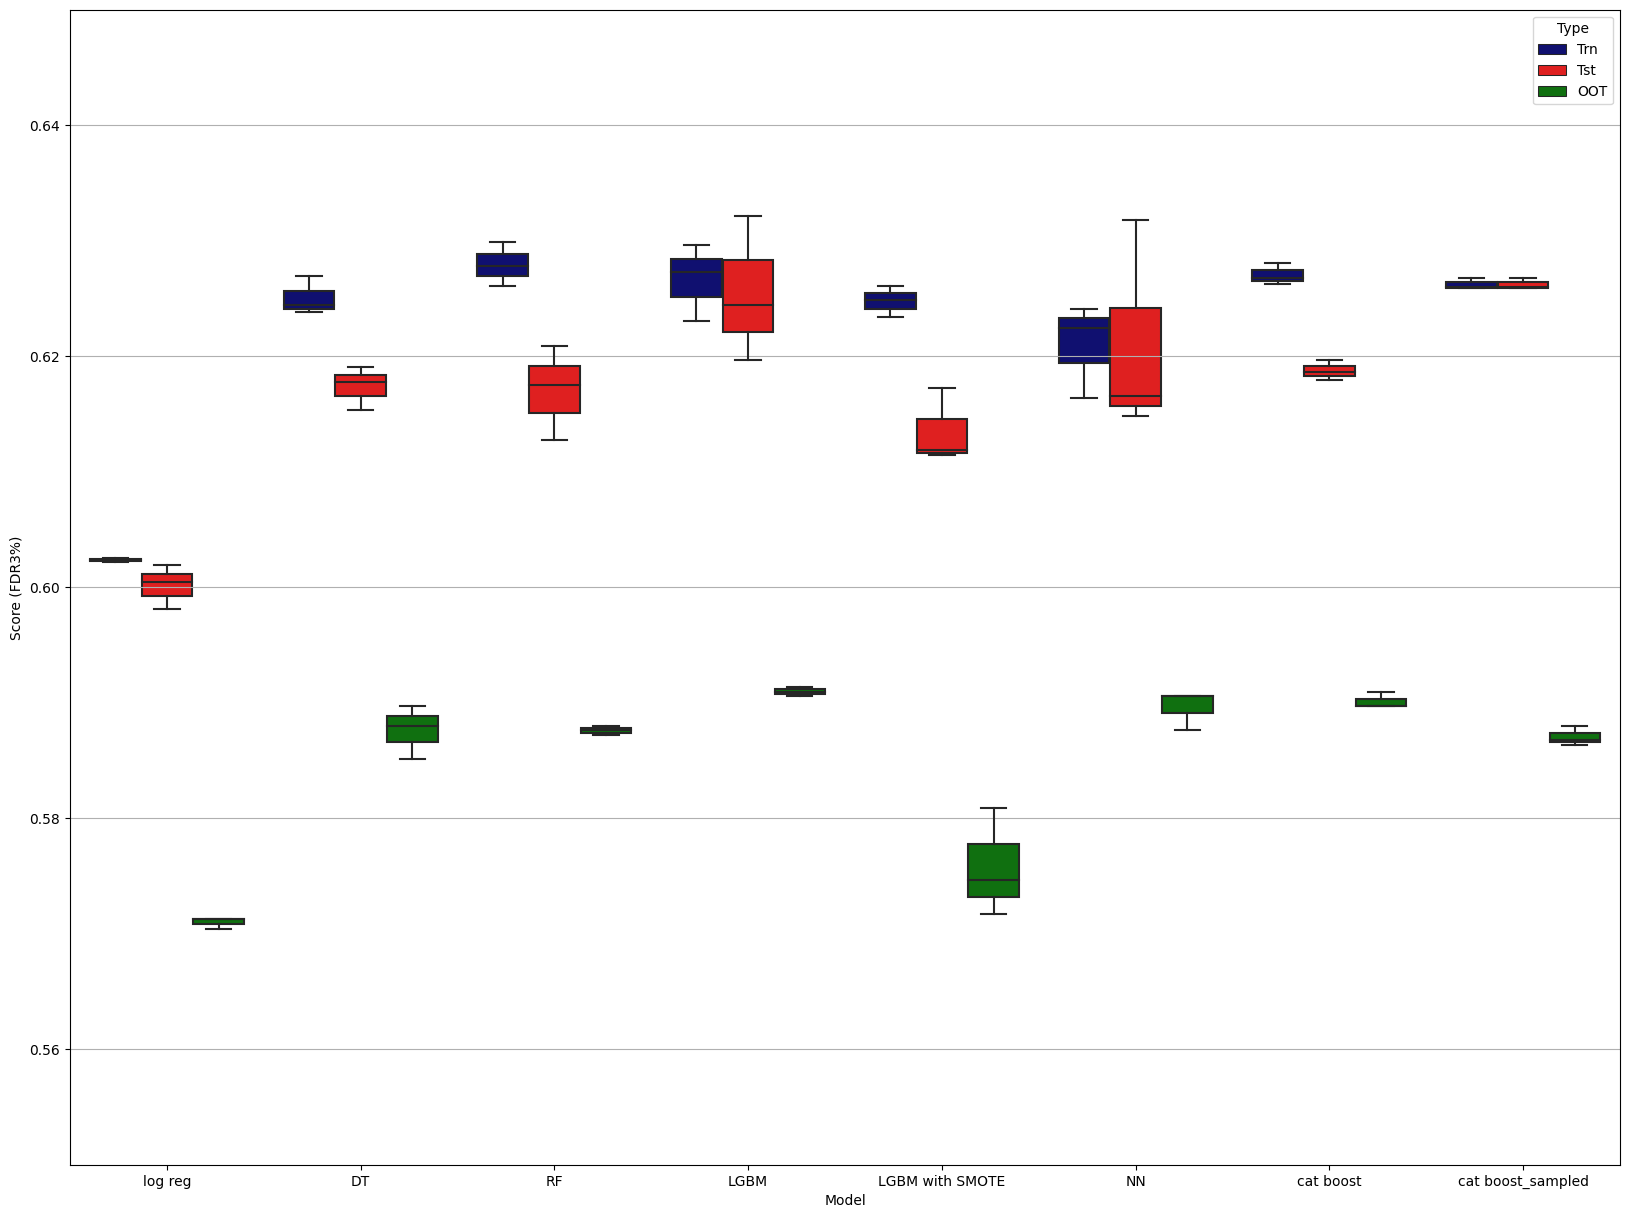

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.55,.65)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [57]:
print('duration: ', datetime.now() - start_time)

duration:  0:01:11.063417


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [58]:
%%time

for niter in range(20):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = lgb.LGBMClassifier(num_leaves=8,n_estimators=200)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .59): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6245701411122969 0.62758813654169 0.5892707460184409
1 0.6271004647836969 0.6255530973451328 0.5913663034367141
trn    0.626157
tst    0.626647
oot    0.589131
dtype: float64
CPU times: user 13.9 s, sys: 795 ms, total: 14.7 s
Wall time: 3.22 s


In [59]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [60]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,predicted,Fraud
957048,10.074014,18.243255,8.543596,1.689311,3.197781,15.85223,15.280956,1.360450,3.269535,17.037019,0.999822,0.0
995653,14.499030,-0.094680,10.309721,10.868526,10.312079,15.85223,15.280956,4.830235,3.279624,3.172909,0.999812,1.0
885388,14.499030,-0.094680,10.309721,10.868526,8.818906,15.85223,15.280956,4.582393,3.279624,3.172909,0.999800,1.0
885806,14.499030,-0.094680,10.309721,10.868526,8.818906,15.85223,15.280956,4.582393,3.279624,-0.138595,0.999545,1.0
885837,14.499030,-0.094680,10.309721,10.868526,8.818906,15.85223,15.280956,4.582393,3.279624,-0.138595,0.999545,1.0
885854,14.499030,-0.094680,10.309721,10.868526,8.818906,15.85223,15.280956,4.582393,3.279624,-0.138595,0.999545,1.0
885671,14.499030,-0.094680,10.309721,10.868526,8.818906,15.85223,15.280956,4.582393,3.279624,-0.138595,0.999545,1.0
995262,14.499030,-0.094680,10.309721,10.868526,10.312079,15.85223,15.280956,4.830235,3.279624,-0.138595,0.999520,1.0
995388,14.499030,-0.094680,10.309721,10.868526,10.312079,15.85223,15.280956,4.830235,3.279624,-0.138595,0.999520,1.0
995699,14.499030,-0.094680,10.309721,10.868526,10.312079,15.85223,15.280956,4.830235,3.279624,-0.138595,0.999520,0.0


In [61]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,385.0,1280.0,23.123123,76.876877,1665.0,385.0,1280.0,0.234603,53.646270,53.411667,0.300781
2,2.0,1665.0,1560.0,105.0,93.693694,6.306306,3330.0,1945.0,1385.0,1.185202,58.046940,56.861738,1.404332
3,3.0,1665.0,1639.0,26.0,98.438438,1.561562,4995.0,3584.0,1411.0,2.183941,59.136630,56.952689,2.540043
4,4.0,1665.0,1648.0,17.0,98.978979,1.021021,6660.0,5232.0,1428.0,3.188164,59.849120,56.660956,3.663866
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1658.0,7.0,99.579580,0.420420,159833.0,157492.0,2341.0,95.969093,98.113998,2.144905,67.275523
97,97.0,1665.0,1660.0,5.0,99.699700,0.300300,161498.0,159152.0,2346.0,96.980628,98.323554,1.342926,67.839727
98,98.0,1665.0,1652.0,13.0,99.219219,0.780781,163163.0,160804.0,2359.0,97.987289,98.868399,0.881110,68.166172
99,99.0,1665.0,1654.0,11.0,99.339339,0.660661,164828.0,162458.0,2370.0,98.995168,99.329422,0.334254,68.547679


# Score Calibration

In [62]:
base = 800
delta = 30
odds_at_base = 1

In [63]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(1000000, 12)

In [64]:
df.head()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,predicted,Fraud
285449,-0.165963,-0.09468,-0.791614,-0.572324,0.387218,-0.132842,-0.100412,0.616925,-0.403104,-0.138595,0.005365,0.0
167068,-0.165963,-0.09468,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,0.369083,-0.403104,-0.138595,0.005100,0.0
196267,-0.165963,-0.09468,1.754352,-0.572324,0.387218,-0.132842,-0.100412,0.369083,-0.403104,-0.138595,0.005524,0.0
394766,-0.165963,-0.09468,1.754352,-0.572324,-0.174894,-0.132842,-0.100412,0.616925,-0.403104,-0.138595,0.006319,0.0
542491,-0.165963,-0.09468,0.905697,-0.572324,-0.174894,-0.132842,-0.100412,-0.126601,2.159671,-0.138595,0.004883,0.0


In [65]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_4653/1461524955.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_raw'].clip(upper=.999, inplace=True)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_4653/1461524955.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

,score_raw,Fraud
862324,0.000413,0.0
559665,0.000430,0.0
399149,0.000471,0.0
399126,0.000472,0.0
431008,0.000472,0.0


In [66]:
calib.shape

(1000000, 2)

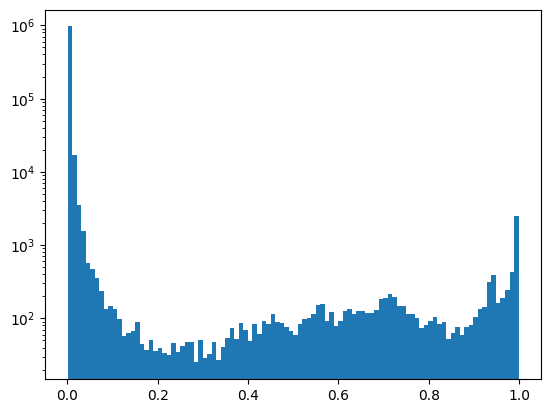

In [67]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [68]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=500
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [69]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

14393.0 985607.0


In [70]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,2000.0,1991.0,9.0,99.55,0.45,2000.0,1991.0,9.0,0.002932,0.45,0.004521,-7.789192,-7.789192
2,2.0,2000.0,1989.0,11.0,99.45,0.55,4000.0,3980.0,20.0,0.003657,0.55,0.005531,-7.498265,-7.498265
3,3.0,2000.0,1990.0,10.0,99.50,0.50,6000.0,5970.0,30.0,0.003766,0.50,0.005026,-7.636480,-7.498265
4,4.0,2000.0,1991.0,9.0,99.55,0.45,8000.0,7961.0,39.0,0.003870,0.45,0.004521,-7.789192,-7.498265
5,5.0,2000.0,1992.0,8.0,99.60,0.40,10000.0,9953.0,47.0,0.003960,0.40,0.004017,-7.959822,-7.498265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,496.0,2000.0,944.0,1056.0,47.20,52.80,992000.0,984613.0,7387.0,0.508673,52.80,1.118645,0.161752,0.161752
497,497.0,2000.0,611.0,1389.0,30.55,69.45,994000.0,985224.0,8776.0,0.681470,69.45,2.273324,1.184803,1.184803
498,498.0,2000.0,293.0,1707.0,14.65,85.35,996000.0,985517.0,10483.0,0.847684,85.35,5.825942,2.542491,2.542491
499,499.0,2000.0,70.0,1930.0,3.50,96.50,998000.0,985587.0,12413.0,0.971218,96.50,27.571443,4.785103,4.785103


In [71]:
cal_bins.tail(20)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
481,481.0,2000.0,1987.0,13.0,99.35,0.65,962000.0,956627.0,5373.0,0.009828,0.65,0.006543,-7.255825,-6.086681
482,482.0,2000.0,1979.0,21.0,98.95,1.05,964000.0,958606.0,5394.0,0.010137,1.05,0.010612,-6.558170,-6.086681
483,483.0,2000.0,1981.0,19.0,99.05,0.95,966000.0,960587.0,5413.0,0.010629,0.95,0.009592,-6.704010,-6.086681
484,484.0,2000.0,1976.0,24.0,98.80,1.20,968000.0,962563.0,5437.0,0.011648,1.20,0.012146,-6.363345,-6.086681
485,485.0,2000.0,1980.0,20.0,99.00,1.00,970000.0,964543.0,5457.0,0.012884,1.00,0.010102,-6.629284,-6.086681
486,486.0,2000.0,1981.0,19.0,99.05,0.95,972000.0,966524.0,5476.0,0.014045,0.95,0.009592,-6.704010,-6.086681
487,487.0,2000.0,1968.0,32.0,98.40,1.60,974000.0,968492.0,5508.0,0.014956,1.60,0.016261,-5.942469,-5.942469
488,488.0,2000.0,1972.0,28.0,98.60,1.40,976000.0,970464.0,5536.0,0.015809,1.40,0.014199,-6.138037,-5.942469
489,489.0,2000.0,1957.0,43.0,97.85,2.15,978000.0,972421.0,5579.0,0.016937,2.15,0.021973,-5.508130,-5.508130
490,490.0,2000.0,1964.0,36.0,98.20,1.80,980000.0,974385.0,5615.0,0.017915,1.80,0.018330,-5.769614,-5.508130


In [72]:
temp = cal_bins.copy()
temp.drop(columns=['bin','log_odds_adj','%g','%b','tot','cg','cb'], inplace=True)
temp.tail(10)

,#recs,#g,#b,score_raw,prob(%),odds,log_odds
491,2000.0,1956.0,44.0,0.019858,2.20,0.022495,-5.474226
492,2000.0,1951.0,49.0,0.024658,2.45,0.025116,-5.315259
493,2000.0,1928.0,72.0,0.030267,3.60,0.037345,-4.742944
494,2000.0,1854.0,146.0,0.048861,7.30,0.078749,-3.666591
495,2000.0,1595.0,405.0,0.197937,20.25,0.253919,-1.977559
496,2000.0,944.0,1056.0,0.508673,52.80,1.118645,0.161752
497,2000.0,611.0,1389.0,0.681470,69.45,2.273324,1.184803
498,2000.0,293.0,1707.0,0.847684,85.35,5.825942,2.542491
499,2000.0,70.0,1930.0,0.971218,96.50,27.571443,4.785103
500,2000.0,20.0,1980.0,0.996690,99.00,99.000050,6.629357


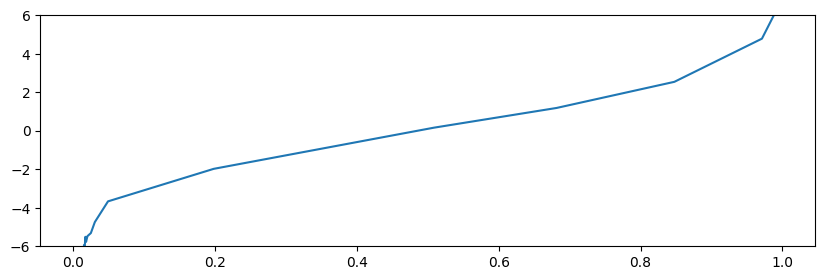

In [73]:
plt.figure(figsize=(10,3))
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])
plt.ylim([-6,6])
plt.show()

In [74]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [75]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.71370102  0.99659256 -0.00347165]


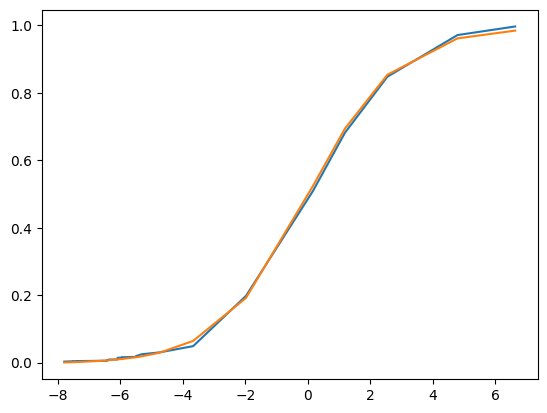

In [76]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


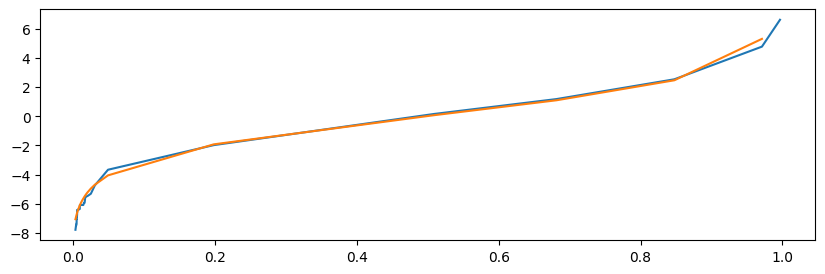

In [77]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(10,3))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [78]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,2000.0,1991.0,9.0,99.55,0.45,2000.0,1991.0,9.0,0.002932,0.45,0.004521,-7.789192,-7.789192,-7.063250
2,2.0,2000.0,1989.0,11.0,99.45,0.55,4000.0,3980.0,20.0,0.003657,0.55,0.005531,-7.498265,-7.498265,-6.911914
3,3.0,2000.0,1990.0,10.0,99.50,0.50,6000.0,5970.0,30.0,0.003766,0.50,0.005026,-7.636480,-7.498265,-6.890425
4,4.0,2000.0,1991.0,9.0,99.55,0.45,8000.0,7961.0,39.0,0.003870,0.45,0.004521,-7.789192,-7.498265,-6.870426
5,5.0,2000.0,1992.0,8.0,99.60,0.40,10000.0,9953.0,47.0,0.003960,0.40,0.004017,-7.959822,-7.498265,-6.853121
6,6.0,2000.0,1992.0,8.0,99.60,0.40,12000.0,11945.0,55.0,0.004019,0.40,0.004017,-7.959822,-7.498265,-6.842053
7,7.0,2000.0,1988.0,12.0,99.40,0.60,14000.0,13933.0,67.0,0.004079,0.60,0.006037,-7.372019,-7.372019,-6.830739
8,8.0,2000.0,1994.0,6.0,99.70,0.30,16000.0,15927.0,73.0,0.004100,0.30,0.003010,-8.376247,-7.372019,-6.826871
9,9.0,2000.0,1991.0,9.0,99.55,0.45,18000.0,17918.0,82.0,0.004129,0.45,0.004521,-7.789192,-7.372019,-6.821332
10,10.0,2000.0,1995.0,5.0,99.75,0.25,20000.0,19913.0,87.0,0.004179,0.25,0.002507,-8.639956,-7.372019,-6.812244


In [79]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_4653/1415719438.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cal_bins['score_calib'].fillna(999, inplace=True)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_4653/1415719438.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

In [80]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
471,471.0,2000.0,1980.0,20.0,99.00,1.00,942000.0,936801.0,5199.0,0.008196,1.00,0.010102,-6.629284,-6.363345,-6.215153,613.545396
472,472.0,2000.0,1984.0,16.0,99.20,0.80,944000.0,938785.0,5215.0,0.008323,0.80,0.008065,-6.954106,-6.363345,-6.199743,614.007708
473,473.0,2000.0,1982.0,18.0,99.10,0.90,946000.0,940767.0,5233.0,0.008516,0.90,0.009082,-6.782736,-6.363345,-6.176779,614.696637
474,474.0,2000.0,1984.0,16.0,99.20,0.80,948000.0,942751.0,5249.0,0.008646,0.80,0.008065,-6.954106,-6.363345,-6.161521,615.154358
475,475.0,2000.0,1984.0,16.0,99.20,0.80,950000.0,944735.0,5265.0,0.008737,0.80,0.008065,-6.954106,-6.363345,-6.150819,615.475418
476,476.0,2000.0,1979.0,21.0,98.95,1.05,952000.0,946714.0,5286.0,0.008937,1.05,0.010612,-6.558170,-6.363345,-6.127749,616.167517
477,477.0,2000.0,1986.0,14.0,99.30,0.70,954000.0,948700.0,5300.0,0.009059,0.70,0.007050,-7.148192,-6.363345,-6.113920,616.582402
478,478.0,2000.0,1971.0,29.0,98.55,1.45,956000.0,950671.0,5329.0,0.009134,1.45,0.014714,-6.086681,-6.086681,-6.105446,616.836628
479,479.0,2000.0,1984.0,16.0,99.20,0.80,958000.0,952655.0,5345.0,0.009362,0.80,0.008065,-6.954106,-6.086681,-6.079991,617.600258
480,480.0,2000.0,1985.0,15.0,99.25,0.75,960000.0,954640.0,5360.0,0.009606,0.75,0.007557,-7.047937,-6.086681,-6.053226,618.403231


In [81]:
calib.head()

,score_raw,Fraud
862324,0.000413,0.0
559665,0.000430,0.0
399149,0.000471,0.0
399126,0.000472,0.0
431008,0.000472,0.0


In [82]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_4653/2868135245.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_calib'].fillna(999, inplace=True)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_4653/2868135245.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

,score_raw,Fraud,score_calib
862324,0.000413,0.0,814.846941
559665,0.000430,0.0,814.847035
399149,0.000471,0.0,814.847251
399126,0.000472,0.0,814.847256
431008,0.000472,0.0,814.847256


In [83]:
calib.tail()

,score_raw,Fraud,score_calib
253444,0.999,1.0,819.95908
157376,0.999,1.0,819.95908
885388,0.999,1.0,819.95908
995653,0.999,1.0,819.95908
957048,0.999,0.0,819.95908


In [84]:
calib.describe()

,score_raw,Fraud,score_calib
count,1000000.000000,1000000.000000,1000000.000000
mean,0.014300,0.014393,814.919720
std,0.081946,0.119104,0.423048
min,0.000413,0.000000,814.846941
25%,0.005149,0.000000,814.872205
50%,0.005423,0.000000,814.873668
75%,0.005984,0.000000,814.876660
max,0.999000,1.000000,819.959080


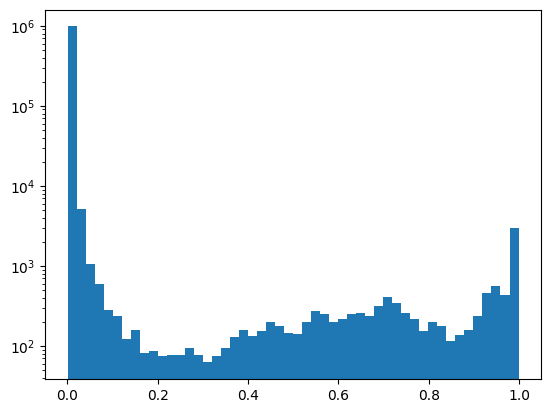

In [85]:
nbins=50
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

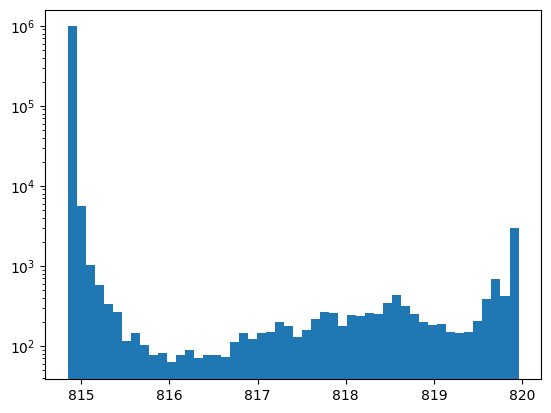

In [86]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

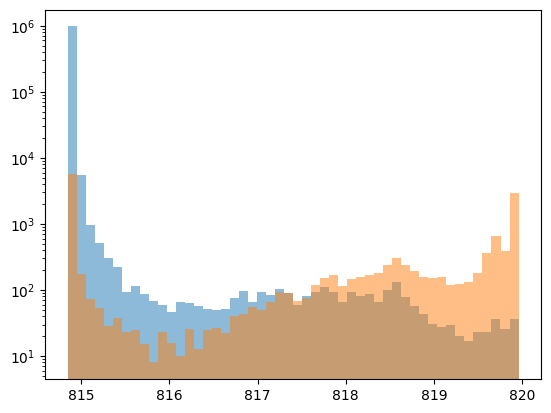

In [87]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [88]:
print("duration: ", datetime.now() - start_time)

duration:  0:01:17.783882


In [89]:
!pwd

/Users/stevecoggeshall/Documents/Teaching/Data sets/done/applications/2025
